## Import all relevant libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

## Load and clean-up data one last time before training

## Includes Feature Engineering

1. One Hot encoding which is possible for QTR/Down/Timeouts
2. Feature normalization for all contintuous variables
3. Add another feature with "previous play"

In [2]:
homepath = r"D:\\Viraj_Work\\NFL Play Predictor\\Data"
os.chdir(homepath)

Final_Data = pd.read_csv('FINAL_PBP_DATA.csv', keep_default_na=False, low_memory=False) #read all the data as list
qtrs = [1,2,3,4]
downs = ['1','2','3','4']
Final_Data = Final_Data[Final_Data['qtr'].isin(qtrs) & Final_Data['down'].isin(downs)]
Final_Data = Final_Data[Final_Data['score_differential'] != 'NA']

Final_Data['down'] = Final_Data['down'].astype(int)
Final_Data['score_differential'] = Final_Data['score_differential'].astype(float)
Final_Data['play_clock'] = Final_Data['play_clock'].astype(float)

play_dict = {'pass': 1, 'run': 0}
Final_Data['play_type'] = Final_Data['play_type'].map(play_dict)

# One hot encoding with dropping first instances
Final_Data = pd.concat([Final_Data,pd.get_dummies(Final_Data['qtr'], prefix='qtr')],axis=1)

# Extract previous play
Final_Data['Prev_Play'] = Final_Data.groupby(['game_id','posteam'])['play_type'].shift().fillna(2)
Final_Data = pd.concat([Final_Data,pd.get_dummies(Final_Data['Prev_Play'], prefix='prev_pass')],axis=1)
Final_Data.drop(['Prev_Play'],axis=1, inplace=True)
Final_Data.drop(['prev_pass_2.0'],axis=1, inplace=True)
Final_Data.to_csv('dummy_prev_play.csv', header=True)

#normalize select features


sc=StandardScaler()
Final_Data[['ydstogo','score_differential',
            'play_clock','yards_to_goal',
            'cum_pass_yards','cum_run_yards']] = sc.fit_transform(Final_Data[['ydstogo','score_differential',
                                                                'play_clock','yards_to_goal',
                                                                'cum_pass_yards','cum_run_yards']])

Final_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333821 entries, 0 to 336966
Data columns (total 24 columns):
game_id                       333821 non-null int64
posteam                       333821 non-null object
defteam                       333821 non-null object
qtr                           333821 non-null int64
desc                          333821 non-null object
shotgun                       333821 non-null int64
no_huddle                     333821 non-null int64
down                          333821 non-null int32
ydstogo                       333821 non-null float64
posteam_timeouts_remaining    333821 non-null int64
score_differential            333821 non-null float64
play_clock                    333821 non-null float64
yards_to_goal                 333821 non-null float64
cum_pass_comp%                333821 non-null float64
cum_pass_yards                333821 non-null float64
cum_run_yards                 333821 non-null float64
teamQB_dual_threat_rating     333821 non

## Separate inpendent/response variables and train/test sets

In [3]:
X_Full = Final_Data[['game_id','posteam','qtr_2','qtr_3','qtr_4', 'down', 'ydstogo', 'shotgun', 'no_huddle',
       'posteam_timeouts_remaining', 'score_differential', 'play_clock',
       'yards_to_goal', 'cum_pass_comp%', 'cum_pass_yards', 'cum_run_yards',
       'teamQB_dual_threat_rating','prev_pass_0.0','prev_pass_1.0']]
y_Full = Final_Data[['play_type']]

print("Following is the information on our dataset\n")
print(X_Full.info())

X_train, X_test,y_train, y_test = train_test_split(X_Full, y_Full, test_size=0.2, random_state=42)

Following is the information on our dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333821 entries, 0 to 336966
Data columns (total 19 columns):
game_id                       333821 non-null int64
posteam                       333821 non-null object
qtr_2                         333821 non-null uint8
qtr_3                         333821 non-null uint8
qtr_4                         333821 non-null uint8
down                          333821 non-null int32
ydstogo                       333821 non-null float64
shotgun                       333821 non-null int64
no_huddle                     333821 non-null int64
posteam_timeouts_remaining    333821 non-null int64
score_differential            333821 non-null float64
play_clock                    333821 non-null float64
yards_to_goal                 333821 non-null float64
cum_pass_comp%                333821 non-null float64
cum_pass_yards                333821 non-null float64
cum_run_yards                 333821 non-null float

In [4]:
X_train_2 = X_train[['qtr_2','qtr_3','qtr_4', 'down', 'ydstogo', 'shotgun', 'no_huddle',
       'posteam_timeouts_remaining', 'score_differential', 'play_clock',
       'yards_to_goal', 'cum_pass_comp%', 'cum_pass_yards', 'cum_run_yards',
       'teamQB_dual_threat_rating','prev_pass_0.0','prev_pass_1.0']]

X_test_2 = X_test[['qtr_2','qtr_3','qtr_4', 'down', 'ydstogo', 'shotgun', 'no_huddle',
       'posteam_timeouts_remaining', 'score_differential', 'play_clock',
       'yards_to_goal', 'cum_pass_comp%', 'cum_pass_yards', 'cum_run_yards',
       'teamQB_dual_threat_rating','prev_pass_0.0','prev_pass_1.0']]

## Logistic Regression

In [5]:
clf2 = LogisticRegression(solver='liblinear')
gs = sklearn.model_selection.GridSearchCV(clf2, param_grid={'C': [1, 10, 100, 1000]}, cv = 5, verbose=3)
gs.fit(X_train_2,y_train.values.ravel())
clf2 = LogisticRegression(C=gs.best_params_['C'], solver='liblinear')
clf2.fit(X_train_2,y_train.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=1 .............................................................
[CV] ........................ C=1, score=0.719632292369, total=   3.9s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ........................ C=1, score=0.719744626676, total=   3.5s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


[CV] ........................ C=1, score=0.720624578746, total=   4.0s
[CV] C=1 .............................................................
[CV] ........................ C=1, score=0.719378393559, total=   4.1s
[CV] C=1 .............................................................
[CV] ........................ C=1, score=0.723066841415, total=   4.6s
[CV] C=10 ............................................................
[CV] ....................... C=10, score=0.719688459522, total=   4.2s
[CV] C=10 ............................................................
[CV] ........................ C=10, score=0.71976334906, total=   4.3s
[CV] C=10 ............................................................
[CV] ....................... C=10, score=0.720624578746, total=   3.9s
[CV] C=10 ............................................................
[CV] ........................ C=10, score=0.71941583973, total=   5.2s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.5min finished


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Weight coefficients are as follows

                             Weights
qtr_2                       0.027882
qtr_3                      -0.188538
qtr_4                      -0.423901
down                        0.540235
ydstogo                     0.368240
shotgun                     1.486618
no_huddle                  -0.003373
posteam_timeouts_remaining -0.151640
score_differential         -0.283508
play_clock                 -0.204186
yards_to_goal               0.046271
cum_pass_comp%              0.606326
cum_pass_yards              0.278876
cum_run_yards              -0.375496
teamQB_dual_threat_rating  -0.458145
prev_pass_0.0              -0.176747
prev_pass_1.0              -0.456718

Training data set score is 0.720567970763

Best C parameter is 10

Test data set score is 0.723253201528

Classification Report

             precision    recall  f1-score   support

          0       0.67      0.66      0.67     27890
          1       0.76      0.77      0.76     38875

avg / t

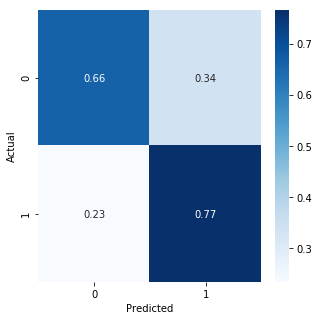

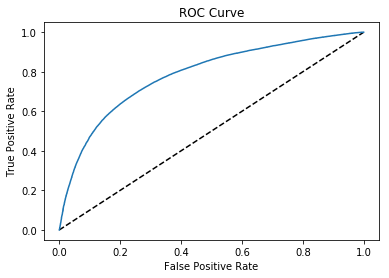

In [6]:
## Print Log Reg weights
print('Weight coefficients are as follows\n')
weights = pd.DataFrame(clf2.coef_.T, index = X_train_2.columns, columns = ['Weights'])
print(weights)

## Training Score
print('\nTraining data set score is {}\n'.format(accuracy_score(clf2.predict(X_train_2),y_train)))

## Hyperparameter and test score
print("Best C parameter is {}\n".format(gs.best_params_['C']))
print('Test data set score is {}\n'.format(accuracy_score(clf2.predict(X_test_2),y_test)))

## Classification report
print('Classification Report\n')
print(classification_report(y_test,clf2.predict(X_test_2)))

## Confustion matrix
print('Confusion Matrix\n')
#labels = ['run', 'pass']
confmat = confusion_matrix(y_test, clf2.predict(X_test_2))
confmat_n = confmat.astype('float')/confmat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(confmat_n, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.axhspan  

## ROC Curve
y_pred_prob = clf2.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve');

## ROC Area

## Decision Trees

In [7]:
clf3 = DecisionTreeClassifier()
param_grid = {'max_depth': np.arange(10, 20)}
gs = sklearn.model_selection.GridSearchCV(clf3, param_grid, cv = 5, scoring='accuracy', verbose=3)
gs_results = gs.fit(X_train_2,y_train.values.ravel())
best_max_depth = gs_results.best_params_['max_depth']
clf3 = DecisionTreeClassifier(max_depth=best_max_depth)
clf3.fit(X_train_2,y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_depth=10 ....................................................
[CV] ............... max_depth=10, score=0.734891035722, total=   1.4s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ............... max_depth=10, score=0.735153149105, total=   1.5s
[CV] max_depth=10 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV] ............... max_depth=10, score=0.736650939864, total=   1.3s
[CV] max_depth=10 ....................................................
[CV] ............... max_depth=10, score=0.736865755477, total=   1.8s
[CV] max_depth=10 ....................................................
[CV] ............... max_depth=10, score=0.740123572365, total=   1.8s
[CV] max_depth=11 ....................................................
[CV] ............... max_depth=11, score=0.736613495095, total=   1.7s
[CV] max_depth=11 ....................................................
[CV] ............... max_depth=11, score=0.735752265409, total=   2.1s
[CV] max_depth=11 ....................................................
[CV] ............... max_depth=11, score=0.739084849846, total=   2.0s
[CV] max_depth=11 ....................................................
[CV] ............... max_depth=11, score=0.736360232166, total=   1.8s
[CV] max_depth=11 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.0min finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Training data set score is 0.75180860943

Best max_depth parameter is 11

Test data set score is 0.738605556804

Classification Report

             precision    recall  f1-score   support

          0       0.69      0.68      0.68     27890
          1       0.77      0.78      0.78     38875

avg / total       0.74      0.74      0.74     66765

Confusion Matrix



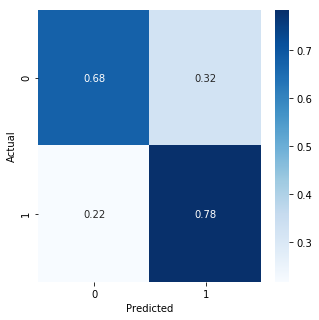

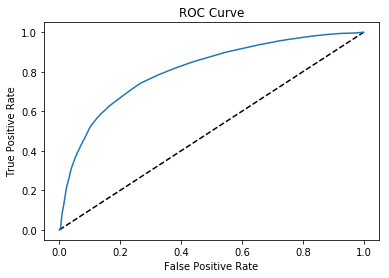

In [8]:
## Training Score
print('\nTraining data set score is {}\n'.format(accuracy_score(clf3.predict(X_train_2),y_train)))

## Hyperparameter and test score
print("Best max_depth parameter is {}\n".format(best_max_depth))
print('Test data set score is {}\n'.format(accuracy_score(clf3.predict(X_test_2),y_test)))

## Classification report
print('Classification Report\n')
print(classification_report(y_test,clf3.predict(X_test_2)))


## Confustion matrix
print('Confusion Matrix\n')
#labels = ['run', 'pass']
confmat = confusion_matrix(y_test, clf3.predict(X_test_2))
confmat_n = confmat.astype('float')/confmat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(confmat_n, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.axhspan    


## ROC Curve
y_pred_prob = clf3.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob);
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve');

## ROC Area

## Random Forest

In [10]:
rf = RandomForestClassifier(random_state = 42)
param_grid = {
            'bootstrap': [True],
            'max_depth': [15, 20, 25],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [2, 4, 6],
            'n_estimators': [1000]
            }
gs = sklearn.model_selection.GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 3)
gs_results = gs.fit(X_train_2,y_train.values.ravel())
best_grid = gs_results.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  38 out of  81 | elapsed: 13.1min remaining: 14.8min
[Parallel(n_jobs=-1)]: Done  66 out of  81 | elapsed: 15.8min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 20.9min finished



Training data set score is 0.830990503864

Best hyperparameters are

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Test data set score is 0.757312963379

Classification Report

             precision    recall  f1-score   support

          0       0.72      0.69      0.71     27890
          1       0.79      0.80      0.79     38875

avg / total       0.76      0.76      0.76     66765

Confusion Matrix



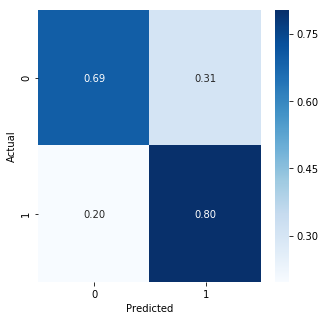

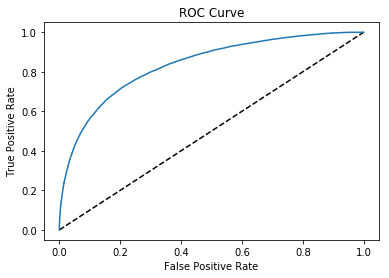

In [11]:
## Training Score
print('\nTraining data set score is {}\n'.format(accuracy_score(best_grid.predict(X_train_2),y_train)))

## Hyperparameter and test score
print("Best hyperparameters are\n")
print(best_grid)
print('\nTest data set score is {}\n'.format(accuracy_score(best_grid.predict(X_test_2),y_test)))

## Classification report
print('Classification Report\n')
print(classification_report(y_test,best_grid.predict(X_test_2)))

## Confustion matrix
print('Confusion Matrix\n')
#labels = ['run', 'pass']
confmat = confusion_matrix(y_test, best_grid.predict(X_test_2))
confmat_n = confmat.astype('float')/confmat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(confmat_n, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.axhspan  

## ROC Curve
y_pred_prob = best_grid.predict_proba(X_test_2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve');

## Discussion and Analysis

In [12]:
def label_qtr (row):
    a = 1
    if row['qtr_2'] == 1:
        a=2
    elif row['qtr_3'] == 1:
        a=3
    elif row['qtr_4'] == 1:
        a=4
    return a
X_test['qtr'] = X_test.apply(lambda row: label_qtr(row), axis=1)
predict_qtr = []
predict_down = []

for i in [1,2,3,4]:
    mask = X_test['qtr'] == i
    temp_X = X_test[mask]
    temp_X = temp_X[['qtr_2','qtr_3','qtr_4', 'down', 'ydstogo', 'shotgun', 'no_huddle',
       'posteam_timeouts_remaining', 'score_differential', 'play_clock',
       'yards_to_goal', 'cum_pass_comp%', 'cum_pass_yards', 'cum_run_yards',
       'teamQB_dual_threat_rating','prev_pass_0.0','prev_pass_1.0']]
    temp_y = y_test[mask]
    predict_qtr.append(accuracy_score(best_grid.predict(temp_X),temp_y))
    print('Segmentation done for qtr {}'.format(i))


for i in [1,2,3,4]:
    mask = X_test['down'] == i
    temp_X = X_test[mask]
    temp_X = temp_X[['qtr_2','qtr_3','qtr_4', 'down', 'ydstogo', 'shotgun', 'no_huddle',
       'posteam_timeouts_remaining', 'score_differential', 'play_clock',
       'yards_to_goal', 'cum_pass_comp%', 'cum_pass_yards', 'cum_run_yards',
       'teamQB_dual_threat_rating','prev_pass_0.0','prev_pass_1.0']]
    temp_y = y_test[mask]
    predict_down.append(accuracy_score(best_grid.predict(temp_X),temp_y))
    print('Segmentation done for down {}'.format(i))

E:\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Segmentation done for qtr 1
Segmentation done for qtr 2
Segmentation done for qtr 3
Segmentation done for qtr 4
Segmentation done for down 1
Segmentation done for down 2
Segmentation done for down 3
Segmentation done for down 4


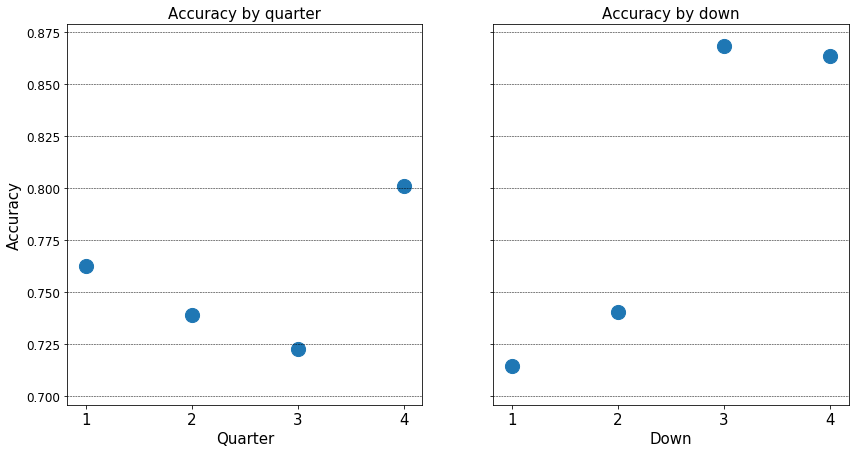

In [13]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_figheight(7)
fig.set_figwidth(14)

ax[0].scatter([1,2,3,4], predict_qtr, s = 200)
ax[0].yaxis.set_tick_params(labelsize=12)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].xaxis.set_tick_params(rotation=0, labelsize=15)
ax[0].set_xlabel('Quarter', fontsize=15)
ax[0].set_title('Accuracy by quarter', fontsize=15);
ax[0].set_xticks([1,2,3,4]) 
ax[0].grid(which='major', axis='y', linestyle='--', linewidth='0.5', color='black')

ax[1].scatter([1,2,3,4], predict_down,s=200)
ax[1].yaxis.set_tick_params(labelsize=12)
ax[1].xaxis.set_tick_params(rotation=0, labelsize=15)
ax[1].set_xlabel('Down', fontsize=15)
ax[1].set_title('Accuracy by down', fontsize=15);
ax[1].set_xticks([1,2,3,4])
ax[1].grid(which='major', axis='y', linestyle='--', linewidth='0.5', color='black')

plt.savefig('Accuracy_qtr_down.png')

Segmentation done for season 2018


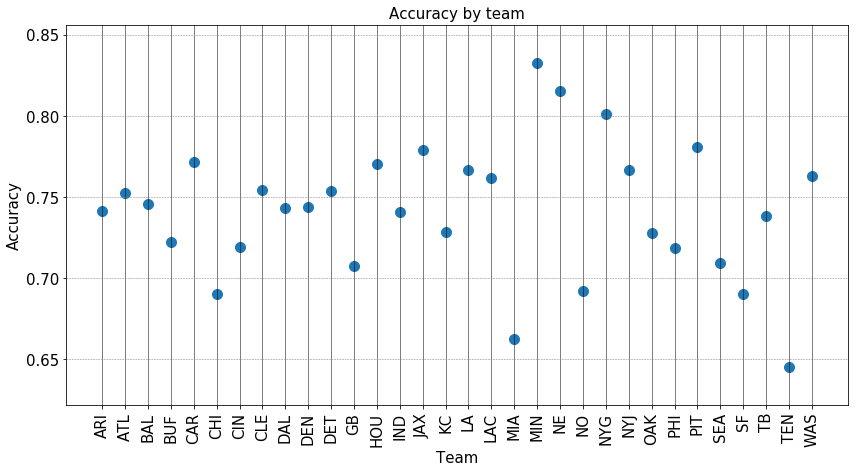

In [20]:
game_dict = {2018: [2018060000, 2018123100]}
team_performance = {}

# mask season games
mask = (game_dict[2018][0] < X_test.game_id) & (X_test.game_id < game_dict[2018][1])
X_game = X_test[mask]
y_game = y_test[mask]

for team in X_game.posteam.unique():
    
    #mask season games for the team
    mask2 = X_game['posteam'] == team
    X_team = X_game[mask2]
    y_team = y_game[mask2] 
    X_team_test = X_team[['qtr_2','qtr_3','qtr_4', 'down', 'ydstogo', 'shotgun', 'no_huddle',
                           'posteam_timeouts_remaining', 'score_differential', 'play_clock',
                           'yards_to_goal', 'cum_pass_comp%', 'cum_pass_yards', 'cum_run_yards',
                           'teamQB_dual_threat_rating','prev_pass_0.0','prev_pass_1.0']]
    team_performance[team] = accuracy_score(best_grid.predict(X_team_test),y_team)
print('Segmentation done for season {}'.format(2018))

x_var = team_performance.keys()
y_var = team_performance.values()
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(14)
ax.scatter(x_var, y_var, s = 100)
ax.grid(which='major', axis='y', linestyle='--', linewidth='0.5', color='grey')
ax.grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='black')

ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.xaxis.set_tick_params(rotation=90, labelsize=15)
ax.set_xlabel('Team', fontsize=15)
ax.set_title('Accuracy by team', fontsize=15);


plt.show()